# Assigment 9
# Extended Kalman filter for navigation and tracking 

## Team 6: Berman Vladimir, Dronova Maria, Bazhenov Artem, Skoltech, October, 2022

## Initialisation of libraries 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Setting functions

### Generating velocity vi and acceleration ai

In [2]:
def gnerate_vel_and_ac(exp, var, T, V0, numb):
    arr = np.zeros(numb)
    a = np.random.normal(exp, var ** 0.5, numb)
    arr[0] = V0
    for i in range(1, len(arr)):
        arr[i] = arr[i - 1] + a[i - 1] * T
    return arr, a

### Generating coordinate xi

In [3]:
def generate_x(T, x0, a, v):
    arr = np.zeros(len(a))
    arr[0] = x0
    for i in range(1, len(a)):
        arr[i] = arr[i - 1] + v[i - 1] * T + a[i - 1] * (T ** 2) / 2
    return arr

### Generating state vector

In [4]:
def generate_trajectory(exp, var, T, x0, vx0, y0, vy0, numb):
    vx, ax = gnerate_vel_and_ac(exp, var, T, vx0, numb)
    x = generate_x(T, x0, ax, vx)
    
    vy, ay = gnerate_vel_and_ac(exp, var, T, vy0, numb)
    y = generate_x(T, y0, ay, vy)
    
    X = np.zeros([numb, 4])
    X[:, 0] = x
    X[:, 1] = vx
    X[:, 2] = y
    X[:, 3] = vy
    
    return X

### Generating true radius D and azimuth Beta

In [5]:
def generate_D(x, y):
    D = np.zeros([len(x), 2])
    for i in range(len(x)):
        D[i, 0] = (x[i] ** 2 + y[i] ** 2) ** 0.5
        D[i, 1] = np.arctan(x[i] / y[i])
    return D

### Generating measurement noises Eta

In [6]:
def generate_eta(sigma_eta_D, sigma_eta_b, N):
    eta = np.zeros([N, 2])
    eta[:, 0] = np.random.normal(0, sigma_eta_D, N)
    eta[:, 1] = np.random.normal(0, sigma_eta_b, N)
    return eta

### Generating measurements z in cartesian coordinates

In [7]:
def generate_z(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b):
    X = generate_X(x0, y0, Vx, Vy, T, N)
    D = generate_D(X[:, 0], X[:, 2])
    sigma_eta_D, sigma_eta_b = 20, 0.02
    eta = generate_eta(sigma_eta_D, sigma_eta_b, N)
    Dm = D + eta
    Zc = trans_to_cart(Dm)
    return Zc, Dm, generate_R(Dm, sigma_eta_D, sigma_eta_b)

### Generating measurements Dm and Betam in polar coordinates

In [8]:
def generate_Dm(D, sigma_eta_D, sigma_eta_b):
    return D + generate_eta(sigma_eta_D, sigma_eta_b, len(D))

### Setting nonlinear function

In [9]:
def h(X):
    x = X[0]
    y = X[2]
    return np.array([(x ** 2 + y ** 2) ** 0.5, np.arctan(x / y)])

### Calculating derivative of nonlinear function

In [10]:
def deriv(Xip):
    xip1 = Xip[0]
    yip1 = Xip[2]
    return np.array([[xip1 / (xip1 ** 2 + yip1 ** 2) ** 0.5, 0, yip1 / (xip1 ** 2 + yip1 ** 2) ** 0.5, 0],
                     [yip1 / (xip1 ** 2 + yip1 ** 2)       , 0, -xip1 / (xip1 ** 2 + yip1 ** 2)      , 0]])

### Constucting extended Kalman filter

In [11]:
def kalman_filt(z, X0, P0, F, Q, R):
    Xf = np.zeros([len(z), len(P0)])
    Xp = np.zeros([len(z), len(P0)])
    Pf = np.zeros([len(z), len(P0), len(P0)])
    Pp = np.zeros([len(z), len(P0), len(P0)])
    K = np.zeros([len(z), len(P0), len(z[0])])
    Xf[0] = X0
    Xp[0] = X0
    Pf[0] = P0
    Pp[0] = P0
    for i in range(len(X) - 1):
        Xp[i + 1] = F.dot(Xf[i])
        Pp[i + 1] = (F.dot(Pf[i])).dot(F.T) + Q
        
        K[i + 1] = (Pp[i + 1].dot(deriv(Xp[i + 1]).T)).dot(np.linalg.inv((deriv(Xp[i + 1]).dot(Pp[i + 1])).dot(deriv(Xp[i + 1]).T) + R))
        
        Xf[i + 1] = Xp[i + 1] + K[i + 1].dot(z[i + 1] - h(Xp[i + 1]))
        Pf[i + 1] = (np.identity(len(P0)) - K[i + 1].dot(deriv(Xp[i + 1]))).dot(Pp[i + 1])
        
    return Xf, generate_D(Xf[:, 0], Xf[:, 2]), generate_D(Xp[:, 0], Xp[:, 2]), Pf, Pp, K

### Calculating errors

In [12]:
def prob(exp, var, T, x0, vx0, y0, vy0, N, sigma_eta_D, sigma_eta_b, X0, P0, F, Q):
    
    err_D = np.zeros([500, N - 3, 2])
    err_D_pred = np.zeros([500, N - 3, 2])
    for i in range(500):
        
        X = generate_trajectory(exp, var, T, x0, vx0, y0, vy0, numb)
        D = generate_D(X[:, 0], X[:, 2])
        
        eta = generate_eta(sigma_eta_D, sigma_eta_b, N)
        Dm = D + eta
        
        R = np.array([[sigma_D_2, 0],
                      [0, sigma_b_2]])
        
        X_filt = kalman_filt(Dm, X0, P0, F, Q, R)
        
        err_D[i, :, 0] = np.array(D[3:, 0] - X_filt[1][3:, 0]) ** 2
        err_D[i, :, 1] = np.array(D[3:, 1] - X_filt[1][3:, 1]) ** 2
        err_D_pred[i, :, 0] = np.array(D[3:, 0] - X_filt[2][3:, 0]) ** 2
        err_D_pred[i, :, 1] = np.array(D[3:, 1] - X_filt[2][3:, 1]) ** 2
        
    final_err = np.zeros([N - 3, 4])
    for i in range(N - 3):
        final_err[i] = np.array([(np.mean(err_D[:, i, 0])) ** 0.5, (np.mean(err_D[:, i, 1])) ** 0.5,
                                (np.mean(err_D_pred[:, i, 0])) ** 0.5, (np.mean(err_D_pred[:, i, 1])) ** 0.5])
    return final_err

## 1. Generating a true trajectory Xi

In [13]:
T = 1
x0 = 1000
y0 = 1000
vx0 = 10
vy0 = 10
sigmaa_2 = 0.3 ** 2
numb = 500
X = generate_trajectory(0, sigmaa_2, T, x0, vx0, y0, vy0, numb)

Text(0.5, 1.0, 'Graph 1\nTrue trajectory in cartesian system')

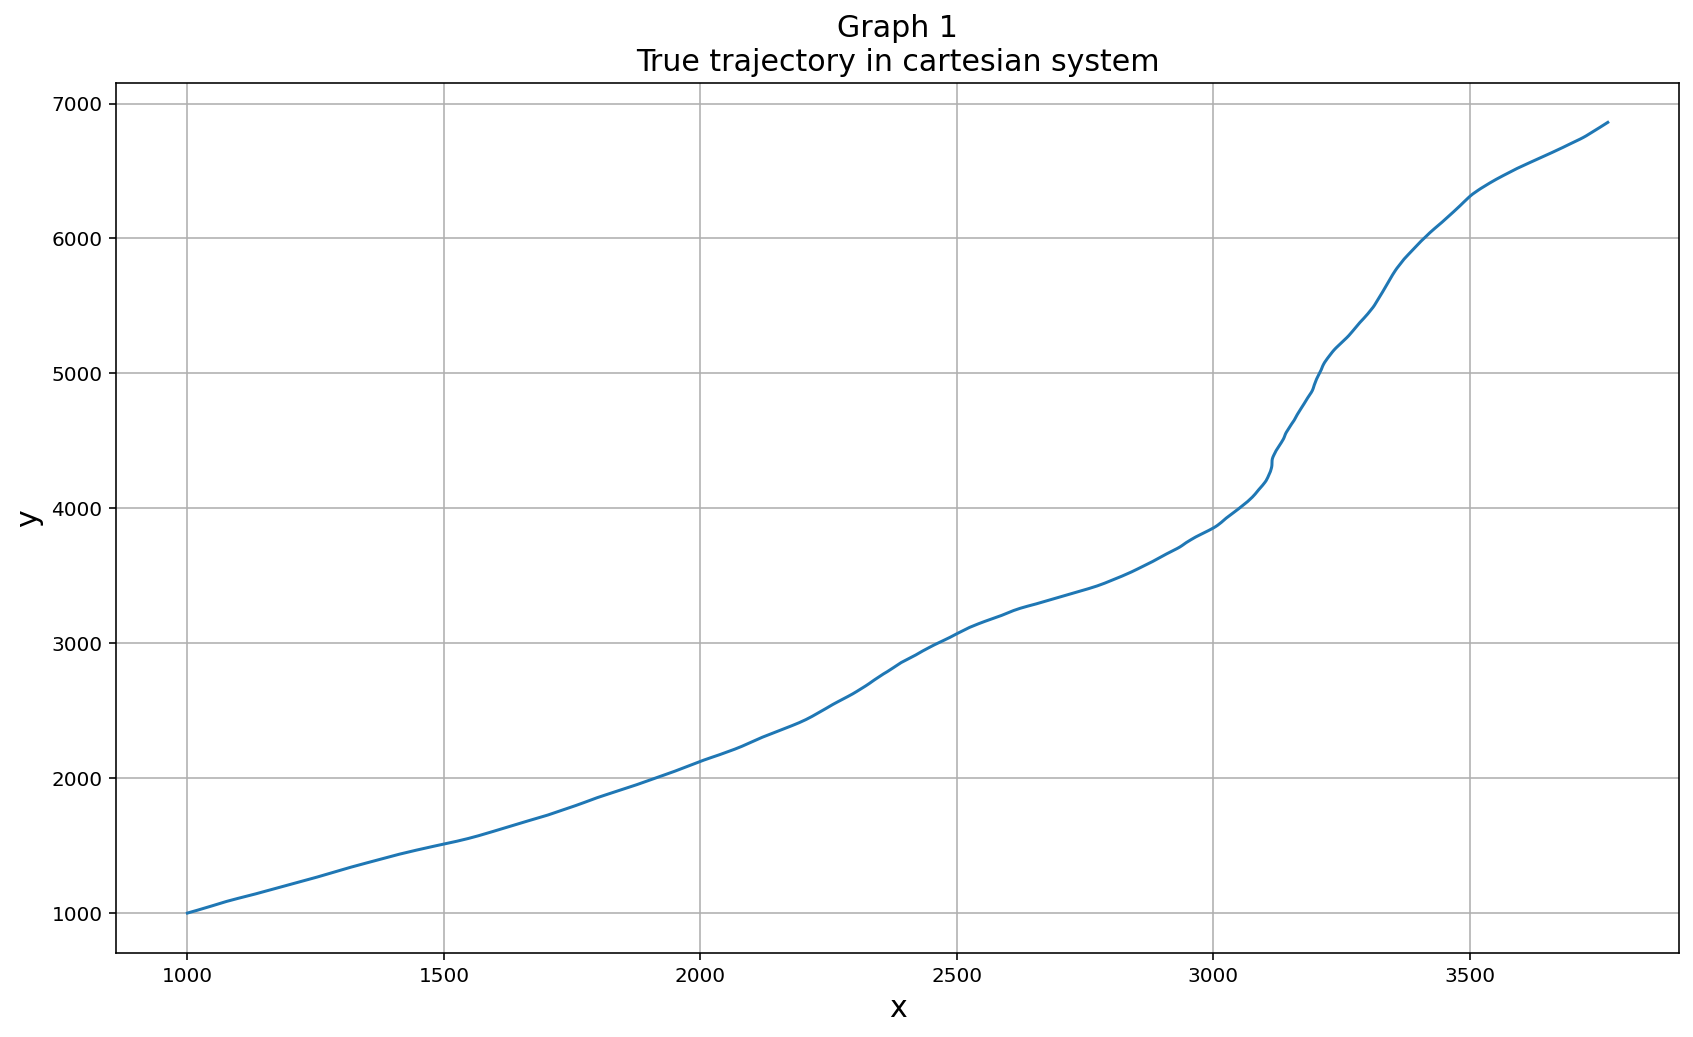

In [14]:
plt.figure(figsize = (14, 8))
plt.plot(X[:, 0], X[:, 2])
plt.grid()
plt.ylabel('y', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.title('Graph 1\nTrue trajectory in cartesian system', fontsize=15)

## 2. Generating true values of range D and azimuth Beta

In [15]:
D = generate_D(X[:, 0], X[:, 2])

Text(0.5, 1.0, 'Graph 2\nTrue trajectory in polar coordinate system')

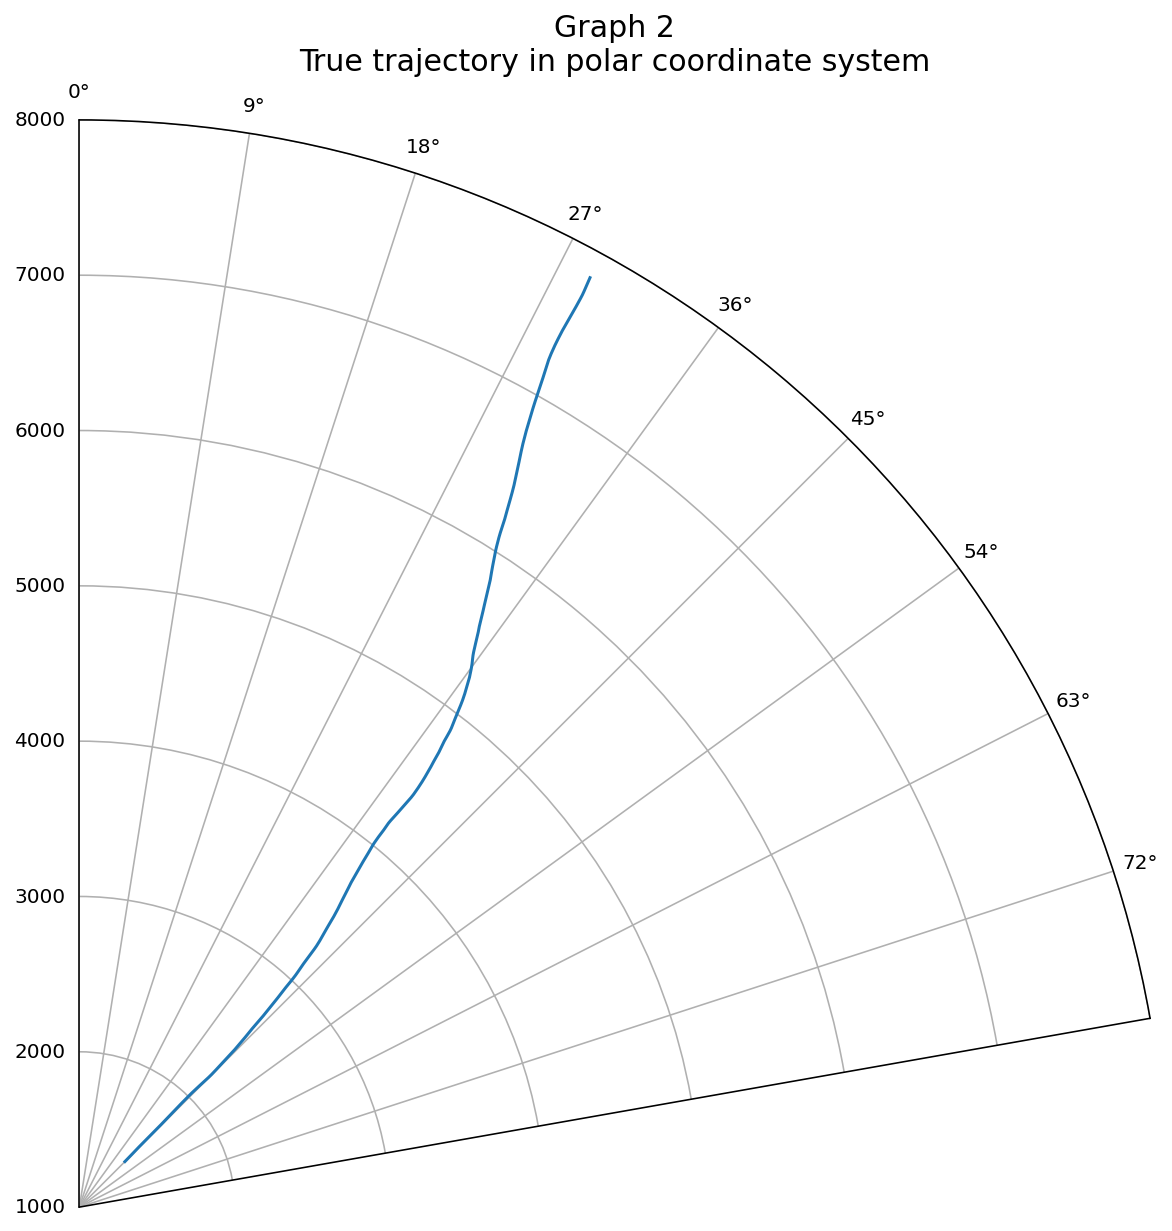

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.polar(D[:, 1], D[:, 0])
ax.set_rlim(1000,8000)
ax.set_xlim([0*(np.pi/180),80*(np.pi/180)])
plt.title('Graph 2\nTrue trajectory in polar coordinate system', fontsize=15)

## 3. Generating measurements Dm and Betam of range D and azimuth Beta

In [17]:
sigma_D_2 = 50 ** 2
sigma_b_2 = 0.004 ** 2

sigma_eta_D = sigma_D_2 ** 0.5
sigma_eta_b = sigma_b_2 ** 0.5

Dm = generate_Dm(D, sigma_eta_D, sigma_eta_b)

Text(0.5, 1.0, 'Graph 3\nMeasurements in polar coordinate system')

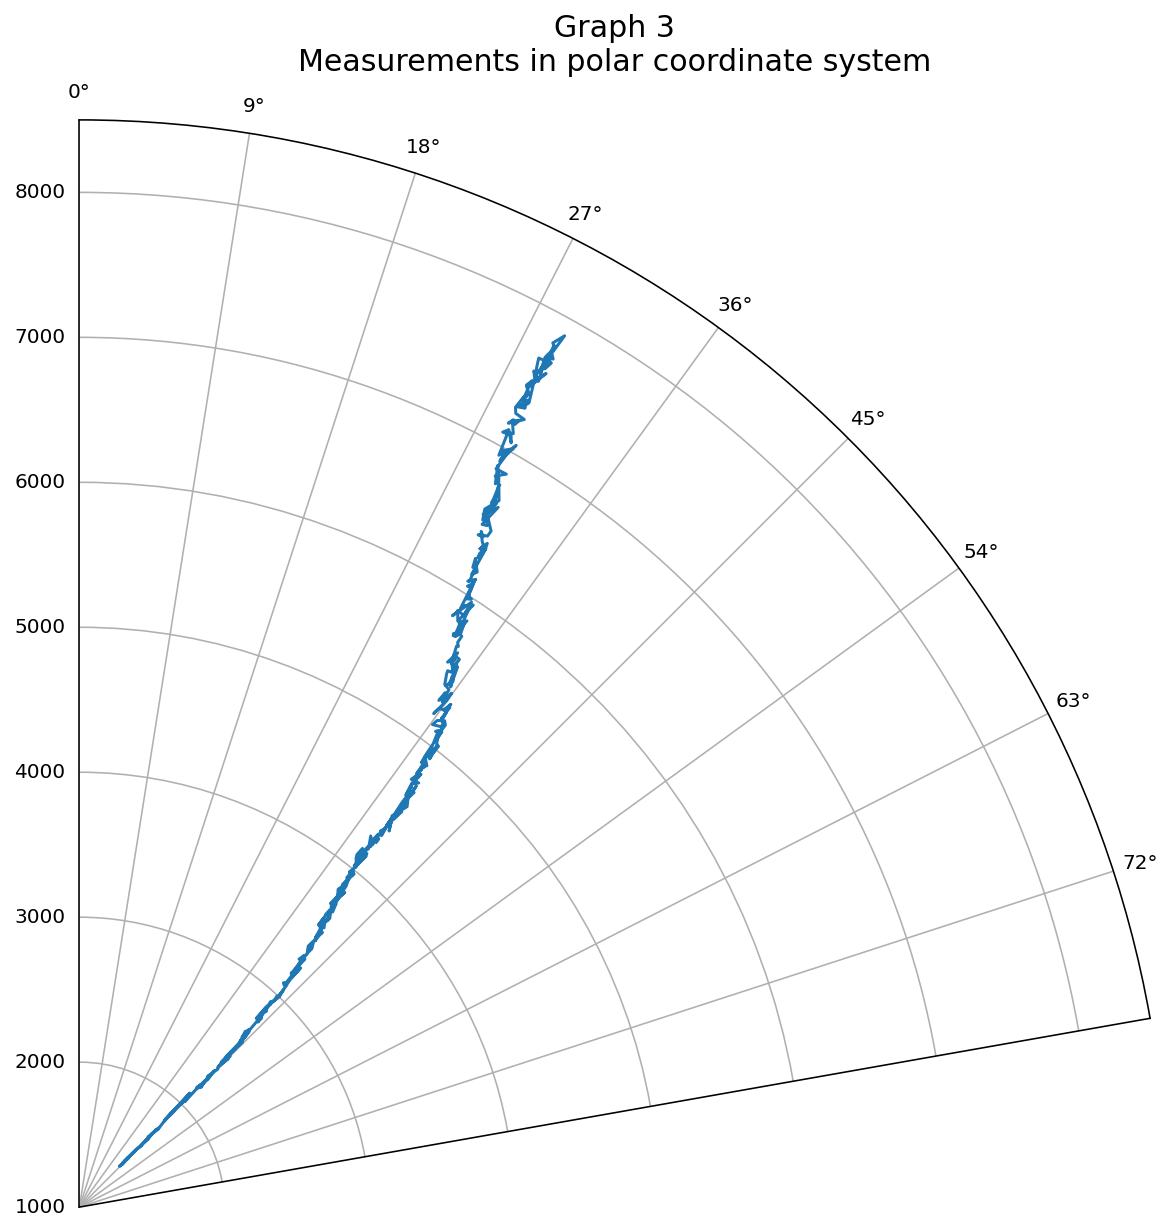

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.polar(Dm[:, 1], Dm[:, 0])
ax.set_rlim(1000,8500)
ax.set_xlim([0*(np.pi/180),80*(np.pi/180)])
plt.title('Graph 3\nMeasurements in polar coordinate system', fontsize=15)

## 4. Initial conditions for Extended Kalman filter algorithm 

In [19]:
# Initial filtered estimate of state vector X0,0
X0 = np.array([Dm[0, 0] * np.sin(Dm[0, 1]),
               0,
               Dm[0, 0] * np.cos(Dm[0, 1]),
               0])
# Initial filtration error covariance matrix  P0,0
P0 = np.array([[10 ** 10, 0, 0, 0],
               [0, 10 ** 10, 0, 0],
               [0, 0, 10 ** 10, 0],
               [0, 0, 0, 10 ** 10]])

## 5. Creating the transition matrix F

In [20]:
F = np.array([[1, T, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, T],
              [0, 0, 0, 1]])

## 6. Calculating state noise covariance matrix Q

In [21]:
# input matrix
G = np.array([[T ** 2 / 2, 0],
              [T,          0],
              [0, T ** 2 / 2],
              [0,          T]])
Q = (G.dot(G.transpose())).dot(sigmaa_2)

## 7. Creating the measurement noise covariance matrix R

In [22]:
R = np.array([[sigma_D_2, 0],
              [0, sigma_b_2]])

## 8-9. Applying extended Kalman filter

In [23]:
X_filt = kalman_filt(Dm, X0, P0, F, Q, R)

Text(0.5, 1.0, 'Graph 5\nFiltered trajectory in polar coordinates')

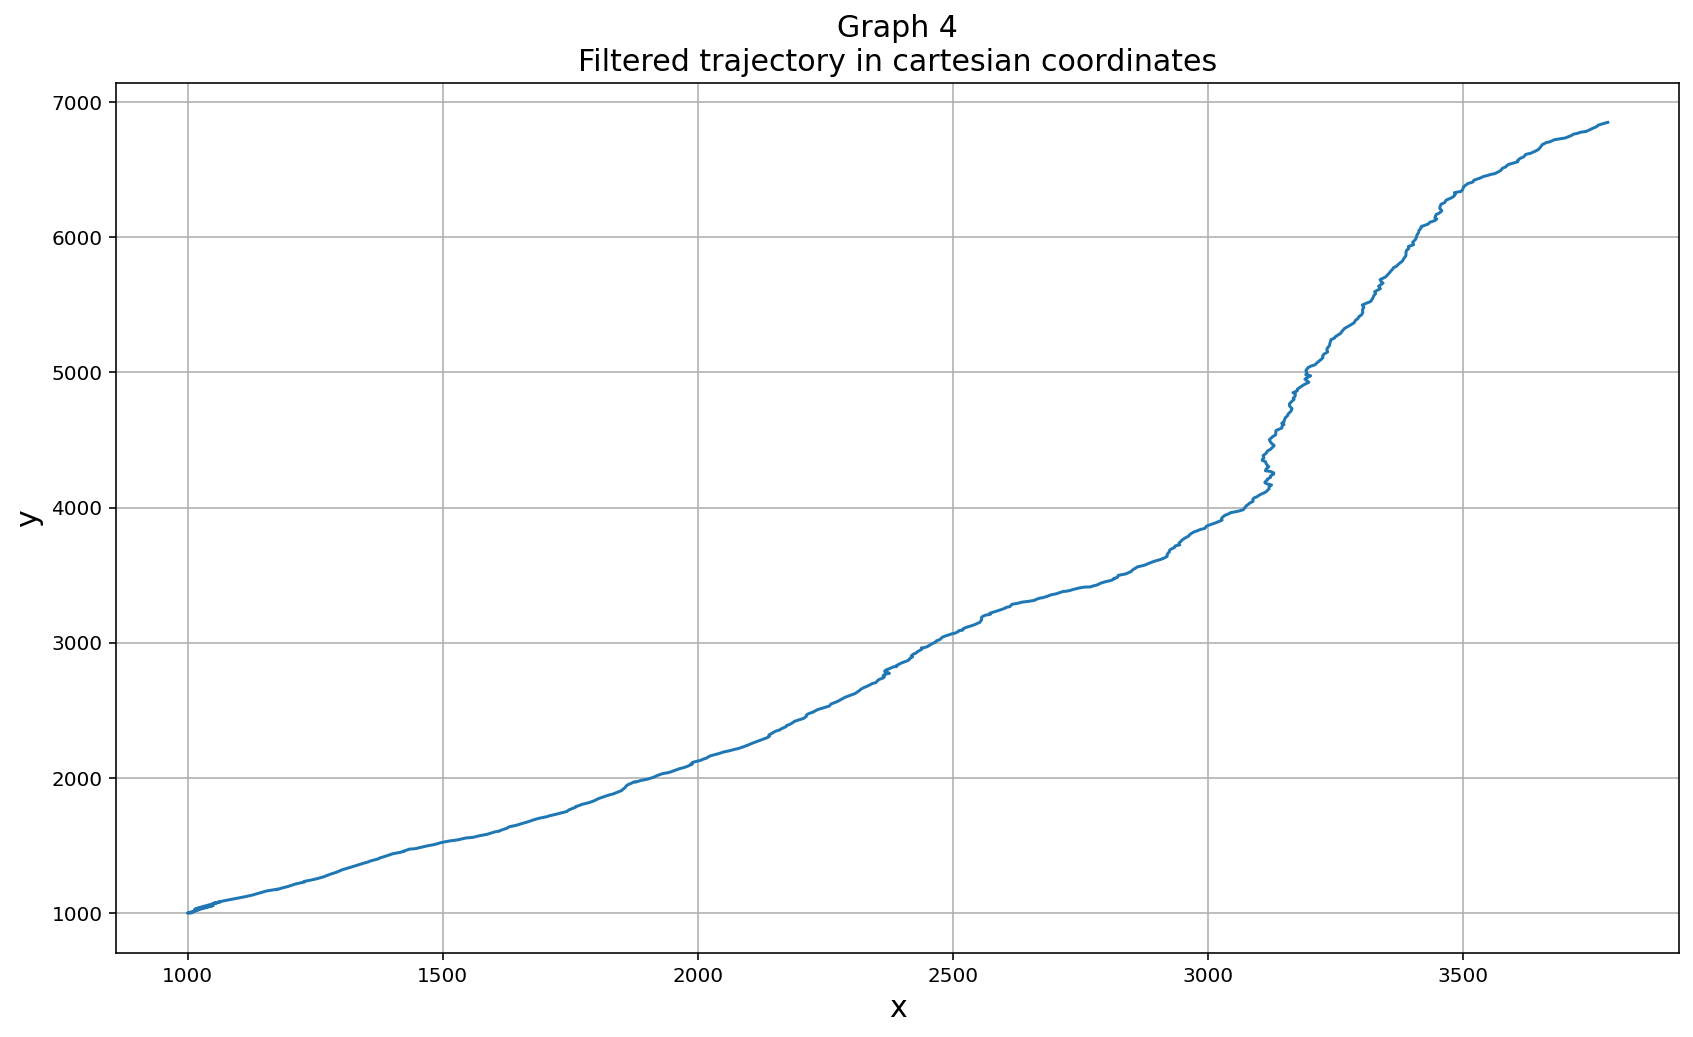

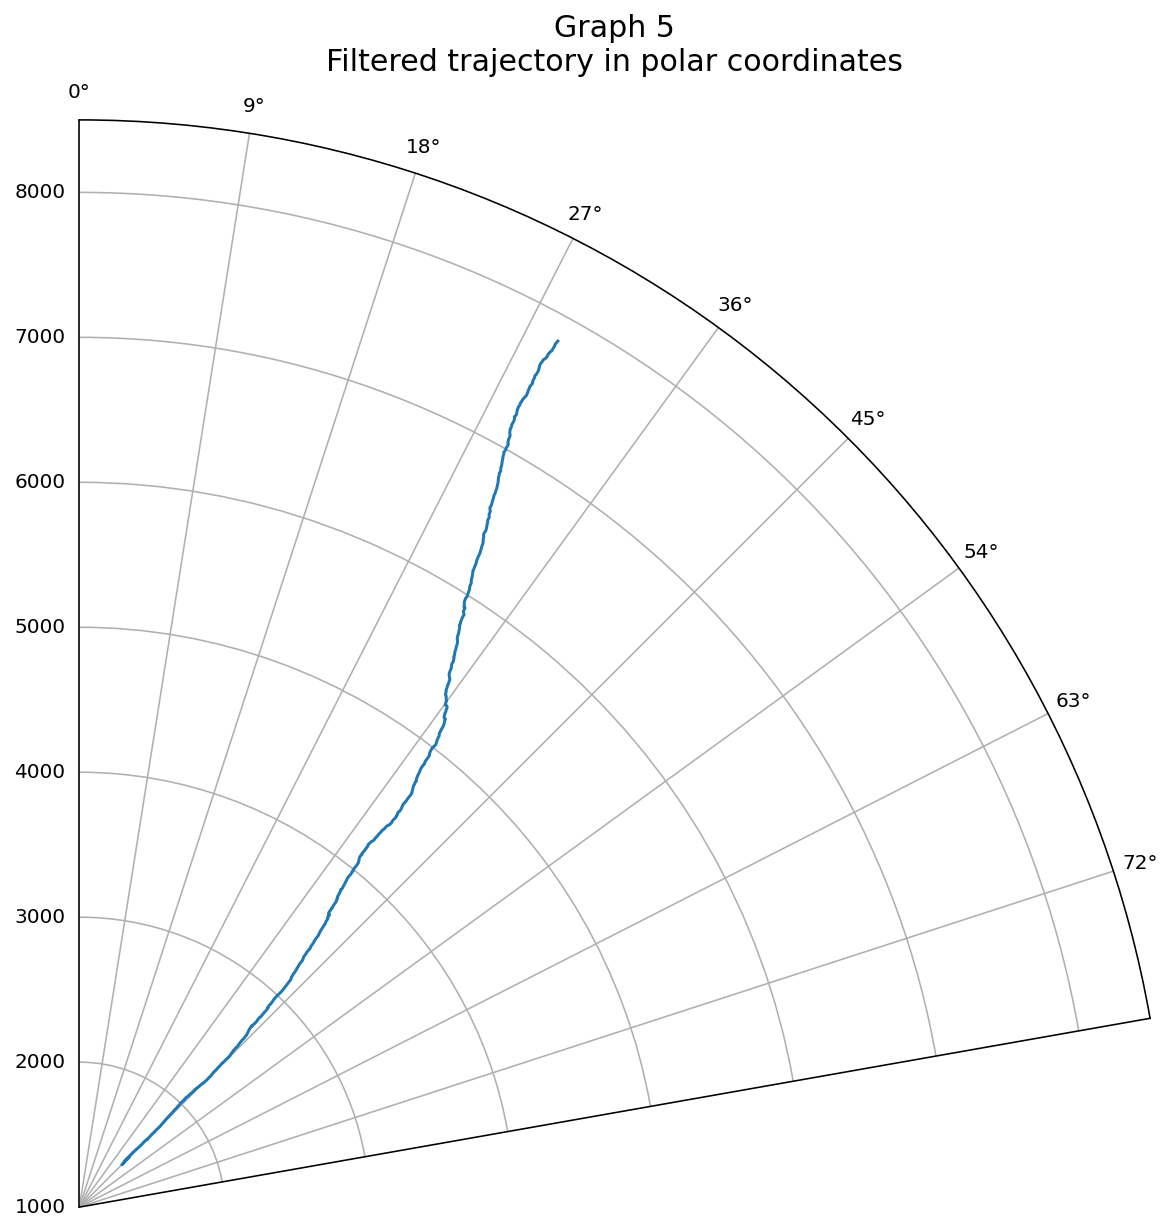

In [24]:
plt.figure(figsize = (14, 8))
plt.plot(X_filt[0][:, 0], X_filt[0][:, 2])
plt.grid()
plt.ylabel('y', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.title('Graph 4\nFiltered trajectory in cartesian coordinates', fontsize=15)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.polar(X_filt[1][:, 1], X_filt[1][:, 0])
ax.set_rlim(1000,8500)
ax.set_xlim([0*(np.pi/180),80*(np.pi/180)])
plt.title('Graph 5\nFiltered trajectory in polar coordinates', fontsize=15)

## 10-11. Calculating true estimation error

In [25]:
final_err = prob(0, sigmaa_2, T, x0, vx0, y0, vy0, numb, sigma_eta_D, sigma_eta_b, X0, P0, F, Q)

Text(0.5, 1.0, 'Graph 6\nErrors of range D')

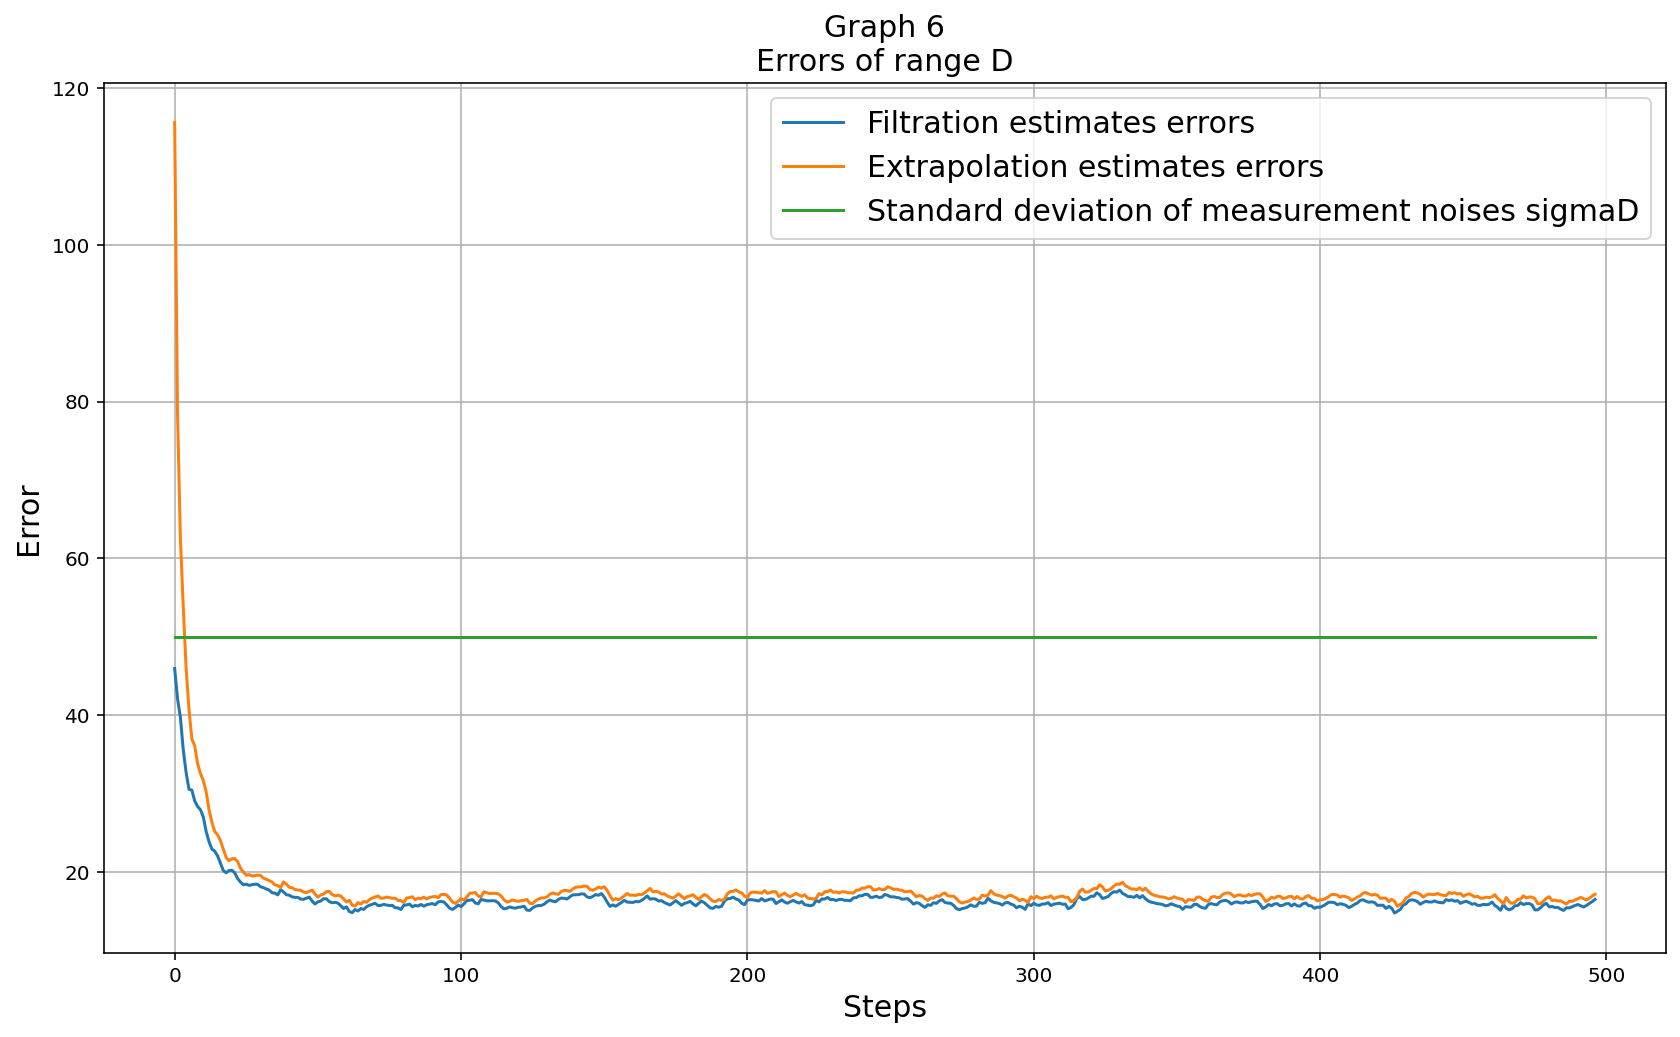

In [28]:
plt.figure(figsize = (14, 8))
plt.plot(final_err[:, 0])
plt.plot(final_err[:, 2])
plt.plot(np.ones(len(final_err[:, 0])) * sigma_eta_D)
plt.grid()
plt.ylabel('Error', fontsize=15)
plt.xlabel('Steps', fontsize=15)
plt.legend(['Filtration estimates errors','Extrapolation estimates errors','Standard deviation of measurement noises sigmaD'], fontsize=15)
plt.title('Graph 6\nErrors of range D', fontsize=15)

Text(0.5, 1.0, 'Graph 7\nErrors of range Beta')

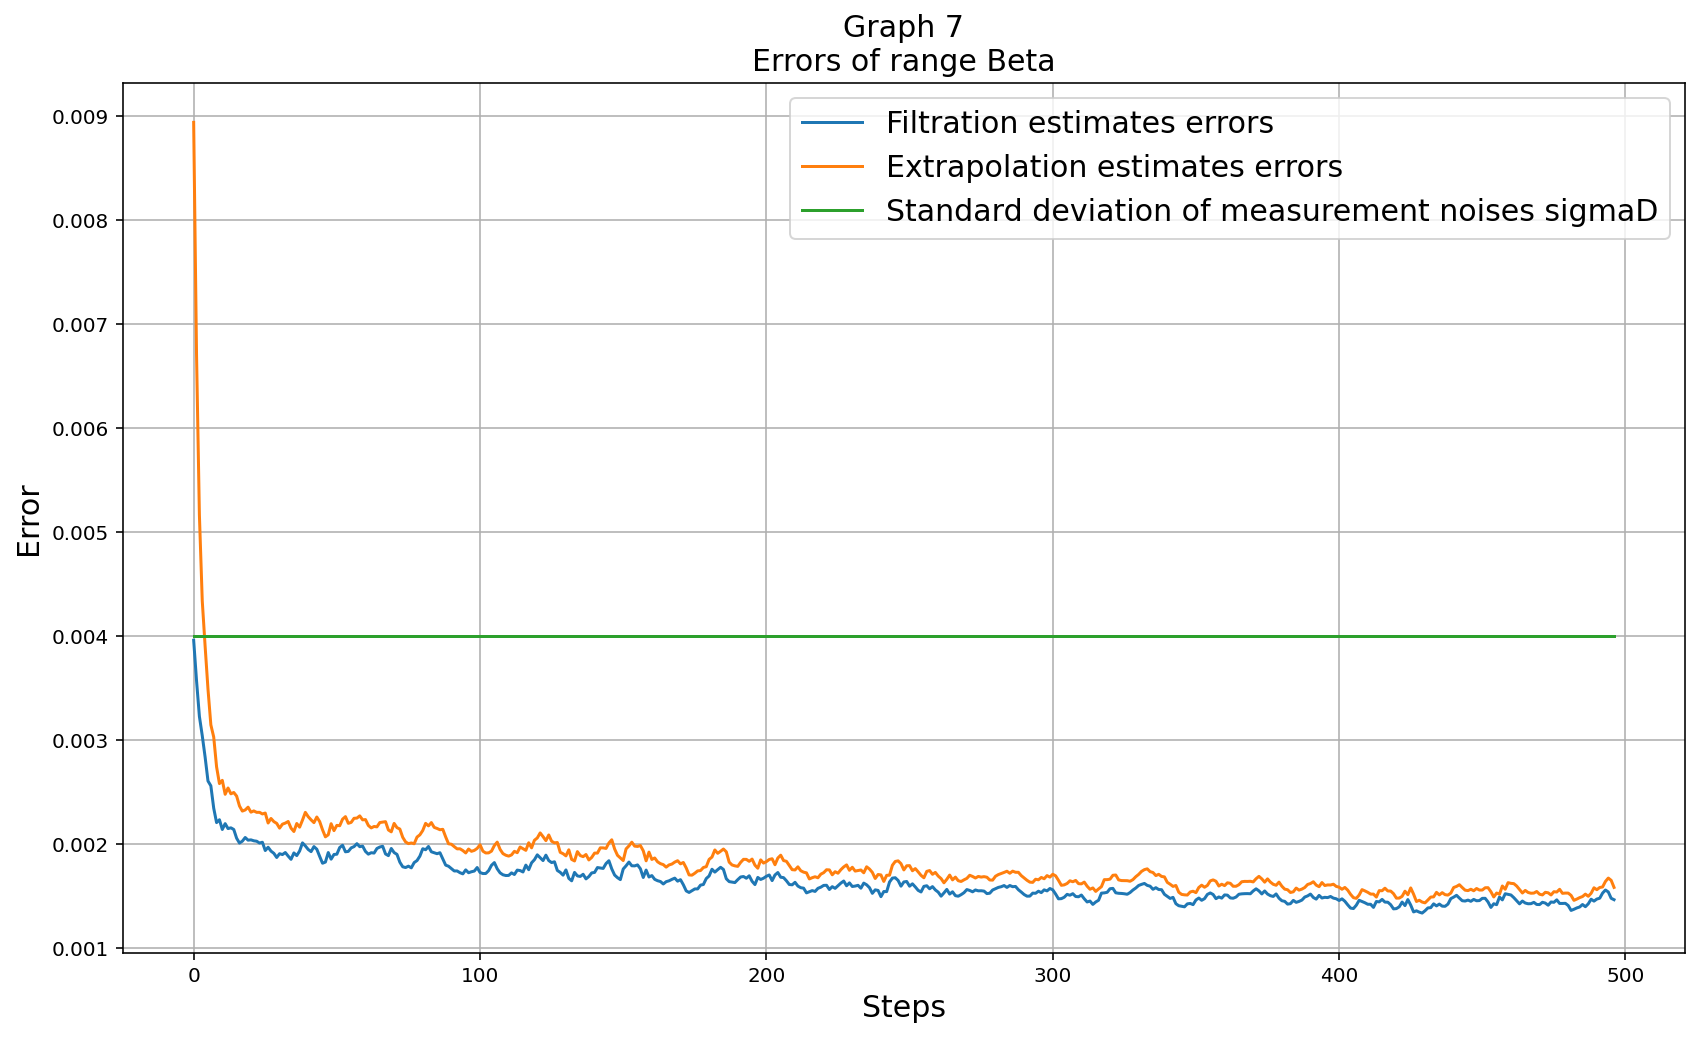

In [29]:
plt.figure(figsize = (14, 8))
plt.plot(final_err[:, 1])
plt.plot(final_err[:, 3])
plt.plot(np.ones(len(final_err[:, 0])) * sigma_eta_b)
plt.grid()
plt.ylabel('Error', fontsize=15)
plt.xlabel('Steps', fontsize=15)
plt.legend(['Filtration estimates errors','Extrapolation estimates errors','Standard deviation of measurement noises sigmaD'], fontsize=15)
plt.title('Graph 7\nErrors of range Beta', fontsize=15) 

## 

## As far as we can see from graphs above, extended Kalman filter works as an effective tool for tracking a moving object when measurements and motion model are in different coordinate system. Errors of both D and Beta ranges are lower then standard deviation of mesurement noise of D and Beta after approximately 10 steps. The difference between "average" Klaman filter for measurements and motion model in different coordinate system from extended one is in calculating derivative of nonlinear function h(Xi). Though the "average" filter is complicated by calculating covariance matrix R for every step. In general, both methods give the same result when applied correctly. 

# Learning log 
## Setting functions and adjusting Kalman filter to its extended version was Vladimir Bermans' part. The main challenge is in keeping multi-dimensional variables in check. 
## The same challenge was a problem for Artem Bazhenov who was making function for calculating all types of errors. 
## Applying functions to the trajectories and drawing up a report was Maria Dronovas' task. 
## In general we understood that there are no resulting difference in usual and extended Kalman filter when they are used correctly.